<a href="https://colab.research.google.com/github/atharvakadam/MNIST/blob/master/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import tensorflow as tf

In [3]:
tf.__version__

'1.15.0'

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta 
import math

##Configuration of our Neural Network

In [0]:
# Convolution Layer 1 

filter_size1 = 5 # size of the every filter in the first layer in pixels
num_filters1 = 16 # number of filters for the first layer

# Convolution Layer 2

filter_size2 = 5 # size of the every filter in the first layer in pixels
num_filters2 = 36 # number of filters for the first layer


# Fully Connected layer
full_connection_size = 128  #Number of neurons in fully connected layer


In [6]:
from tensorflow.examples.tutorials.mnist import input_data 
data = input_data.read_data_sets('data/MNIST/',one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))

Size of:
- Training-set:		55000
- Validation-set:	5000
- Test-set:		10000


In [0]:
data.test.cls = np.argmax(data.test.labels, axis=1)

##Data Dimensions

In [0]:
#MNIST Images are 28 pixels in size
img_size = 28

#Images are stored in one dimensional array of this length- Every square box of pixel is stored with a dot product value for white or black based on the pixel
img_flat_size = img_size * img_size

#A tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

In [0]:
# Number of color channels - 1 channel for grayscale
num_channels = 1

# One class each for each of the 10 digits
num_classes = 10

Helper Functions for Plotting Images

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

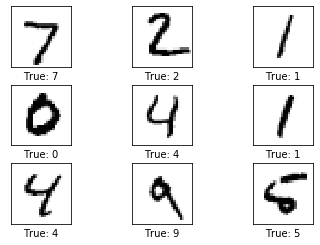

In [12]:
# Get first 9 images 
images = data.test.images[0:9]

# get their true classes from the array of true values calculated earlier
cls_true = data.test.cls[0:9]

# use plot images helper function to plot first nine images with their true class values
plot_images(images=images, cls_true=cls_true)

### Helper Functions to update model variables


In [0]:
def new_weight(shape):
    return tf.Variable(tf.truncated_normal(shape,stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05,shape=[length]))    

### Helper Functions for creating a new Convolution Layer


This is the part where we add mathematical formulas to the Tensorflow graph. We assume that the input is a 4-dimensional tensor with the dimensions being the following:-
1. Image Number
2. X-axis of each Image
3. Y-axis  of each Image
4. Channels of each Image

The input channels can be color channel or filter channels based on the fact that the input is produced from the previous convolution layer.

The output tensor is also 4-dimensional:-
1. Image Number, same as the input
2. X-axis of each image. If 2x2 pooling is used, then the width of images is divided by 2.
3. Y-axis of the image. If 2x2 pooling is used, then the width of images is divided by 2.
4. Channels produced by each of the convolution layers.


In [0]:
def new_conv_layer(input,                  # previous layer
                   num_input_channels,     # Num of channels in prev layer
                   filter_size,            # Width and Height of each filter
                   num_filters,            # Num of filters
                   use_pooling=True):      # Use 2x2 pooling


    # Shape of filter weights for the convolution. 
    # This Format determined by the tensorlflow API
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    #Create new weights aka filters with the given shape
    weights = new_weight(shape=shape)

    #Create new biases for each filter 
    biases = new_biases(length=num_filters)

    # Create Tensorflow operation for new convolution.
    # Note that strides are set to 1 in all dimensions.
    # The first and last stride must always be 1 because 
    # first is for image number and last is for input channel.
    # For eg. [1,2,2,1] would mean that filter is moved 2 pixels across x 
    # and y-axis of the image
    # The padding is also set to "SAME" which means that the input image is 
    # padded with zeroes, so the size of the output is same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1,1,1,1],
                         padding='SAME')
    
    # Add the biases to the result of the convolution
    # A bias value is added to each filter-channel
    layer += biases

    #Use pooling to down sample image resolution
    if use_pooling:
       # this is a 2x2 max-pooling which means that we consider 2x2 windows
       # and select the largest value in each window. Then we move 2 pixels
       # to the next window
       layer = tf.nn.max_pool(value=layer,
                              ksize=[1,2,2,1],
                              strides=[1,2,2,1],
                              padding='SAME')
    # Rectified Linear Unit (ReLU)
    # It calculates max(x, 0) for each pixel, basically changing all -1s to 0s
    # This adds some non-linearity to the formula.
    layer = tf.nn.relu(layer)   

    # ReLU is normally executed before the pooling, but since relu(max_pool(x))
    # == max_pool(relu(x)) we can save 75% of the operations by pooling first.

    # We return both the resulting layer and weights because we will use both of 
    # them later, and we will plot the weights.

    return layer, weights


                

              




### Helper Function for flattening a layer

In [0]:
def flatten_layer(layer):
    # Get the shape of the input layer
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape = [num_images, img_width, img_height, num_channels]

    # The number of features is: img_width * img_height * num_channels 
    # The shape uses a tensorflow datatype, so convert it to numpy.
    num_features = np.array(layer_shape[1:4], dtype=int).prod()

    # Reshape the layer to [num_images, num_features]
    # Note that we just set the size of the second dimension to num_features
    # and size of first dimension to -1 which means that size in that dimension
    # is calculated so total size of the tensor is unchanged from the reshaping. 
    layer_flat = tf.reshape(layer, [-1,num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_width * img_height * num_channesls]
    
    # Return both flattened layer and number of features 
    return layer_flat, num_features

In [0]:
def new_fc_layer(input,           # Previous layer
                 num_inputs,      # Num. of Inputs from prev layer
                 num_outputs,     # Num. of outputs 
                 use_relu=True):   # Use Rectified Linear Unit (ReLU) ? 


    # Create weights and biases 
    weights = new_weight(shape=[num_inputs,num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as matrix multiplication of inputs and weights, then
    # add bias values
    layer = tf.matmul(input, weights) + biases

    # use ReLU ?
    if use_relu:
       layer = tf.nn.relu(layer)


    return layer
                   


### Placeholder Variables 
Placeholder variables serve as an input for the tensorflow computational graph, that we may change every time we execute the graph.

First we define a placeholder variable for the input images. This allows us to change the images that are input to the graph. This is a so called tensor which just means that it is multi dimensional vector or a matrix. The data-type is set to float32 and shape is set to [None, img_size-flat], where None means that the tensor might hold an arbitrary number of images with each image being a vector of length img_size_flat.


In [0]:
x = tf.placeholder(tf.float32, shape=[None,img_flat_size], name='x')

The convolutional layers expect x to be encoded as a 4-dim tensor so we have to reshape it so its shape is instead [num_images, img_height, img_width, num_channels]. Note that img_height == img_width == img_size and num_images can be inferred automatically by using -1 for the size of the first dimension. So the reshape operation is:

In [0]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

Next we have the placeholder variable for the true labels associated with the images that were input in the placeholder variable x. The shape of this placeholder variable is [None, num_classes] which means it may hold an arbitrary number of labels and each label is a vector of length num_classes which is 10 in this case.

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

We could also have a placeholder variable for the class-number, but we will instead calculate it using argmax. Note that this is a TensorFlow operator so nothing is calculated at this point.

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

### Convolution Layer 1
Here we create the first convolution layer. We use the x_image as the input with num_filters1 number of filters, each of the filter_size1 size.We also wish to down sample the image so it is half the size by using 2x2 pooling

In [0]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

Check the shape of the tensor that will be output by the convolutional layer. It is (?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?), each image is 14 pixels wide and 14 pixels high, and there are 16 different channels, one channel for each of the filters.

In [22]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

### Convolution Layer 2
Create the second convolutional layer, which takes as input the output from the first convolutional layer. The number of input channels corresponds to the number of filters in the first convolutional layer



In [0]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

Check the shape of the tensor that will be output from this convolutional layer. The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images, with each image having width and height of 7 pixels, and there are 36 channels, one for each filter.

In [24]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

### Flatten Layer
The convolutional layers output 4-dim tensors. We now wish to use these as input in a fully-connected network, which requires for the tensors to be reshaped or flattened to 2-dim tensors.

In [0]:
layer_flat, num_features = flatten_layer(layer_conv2)

Check that the tensors now have shape (?, 1764) which means there's an arbitrary number of images which have been flattened to vectors of length 1764 each. Note that 1764 = 7 x 7 x 36.

In [26]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [27]:
num_features

1764

### Fully Connected Layer 1
Add a fully-connected layer to the network. The input is the flattened layer from the previous convolution. The number of neurons or nodes in the fully-connected layer is fc_size. ReLU is used so we can learn non-linear relations.

In [0]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=full_connection_size,
                         use_relu=True)

Check that the output of the fully-connected layer is a tensor with shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128.

In [29]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

### Fully Connected Layer 2
Add another fully-connected layer that outputs vectors of length 10 for determining which of the 10 classes the input image belongs to. Note that ReLU is not used in this layer.

In [0]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=full_connection_size,
                         num_outputs=num_classes,
                         use_relu=False)


In [31]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

### Predicted Class
The second fully-connected layer estimates how likely it is that the input image belongs to each of the 10 classes. However, these estimates are a bit rough and difficult to interpret because the numbers may be very small or large, so we want to normalize them so that each element is limited between zero and one and the 10 elements sum to one. This is calculated using the so-called softmax function and the result is stored in y_pred.

In [0]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element.

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cross function to guide optimization
To make the model better, we need to update the model variables somehow.To do this we first need to know how well the model currently performs by comparing the predicted output of the model y_pred to the desired output y_true.

The cross-entropy is a performance measure used in classification. The cross-entropy is a continuous function that is always positive and if the predicted output of the model exactly matches the desired output then the cross-entropy equals zero. The goal of optimization is therefore to minimize the cross-entropy so it gets as close to zero as possible by changing the variables of the network layers.

TensorFlow has a built-in function for calculating the cross-entropy. Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly rather than y_pred which has already had the softmax applied.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2,
                                                        labels=y_true)

We have now calculated the cross-entropy for each of the image classifications so we have a measure of how well the model performs on each image individually. But in order to use the cross-entropy to guide the optimization of the model's variables we need a single scalar value, so we simply take the average of the cross-entropy for all the image classifications.

In [0]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Function
Now that we have a cost measure that must be minimized, we can then create an optimizer. In this case it is the AdamOptimizer which is an advanced form of Gradient Descent.

Note that optimization is not performed at this point. In fact, nothing is calculated at all, we just add the optimizer-object to the TensorFlow graph for later execution.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

###Performance Measures
We need a few more performance measures to display the progress to the user.

This is a vector of booleans whether the predicted class equals the true class of each image.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

This calculates the classification accuracy by first type-casting the vector of booleans to floats, so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Creating a tensorflow session

In [0]:
session = tf.Session()

In [0]:
# initialize variables
session.run(tf.global_variables_initializer())

### Helper function to perform optimization iterations

In [0]:
# Set batch size
train_batch_size = 64

Function for performing a number of optimization iterations so as to gradually improve the variables of the network layers. In each iteration, a new batch of data is selected from the training-set and then TensorFlow executes the optimizer using those training samples. The progress is printed every 100 iterations.

In [0]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(batch_size=train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper function to plot example errors

In [0]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper function for confusion matrix

In [0]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Helper function for printing classification accuracy on test set


In [0]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

### Initial performance without any optimization

In [46]:
print_test_accuracy()

Accuracy on Test-Set: 9.6% (957 / 10000)


### Performance with one optimization

In [47]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   9.4%
Time usage: 0:00:00


In [48]:
print_test_accuracy()

Accuracy on Test-Set: 10.1% (1005 / 10000)


### Performance after 100 optimizations

In [49]:
optimize(num_iterations=99)

Time usage: 0:00:07


Accuracy on Test-Set: 68.0% (6799 / 10000)
Example errors:


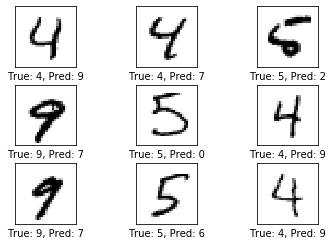

In [50]:
print_test_accuracy(show_example_errors=True)

###Performance after 1000 optimizations

In [51]:
optimize(num_iterations=900)

Optimization Iteration:    101, Training Accuracy:  71.9%
Optimization Iteration:    201, Training Accuracy:  65.6%
Optimization Iteration:    301, Training Accuracy:  87.5%
Optimization Iteration:    401, Training Accuracy:  87.5%
Optimization Iteration:    501, Training Accuracy:  87.5%
Optimization Iteration:    601, Training Accuracy:  89.1%
Optimization Iteration:    701, Training Accuracy:  89.1%
Optimization Iteration:    801, Training Accuracy:  90.6%
Optimization Iteration:    901, Training Accuracy:  85.9%
Time usage: 0:01:01


Accuracy on Test-Set: 93.5% (9352 / 10000)
Example errors:


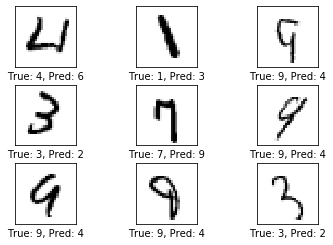

In [52]:
print_test_accuracy(show_example_errors=True)

###Performance after 1000 optimizations

In [53]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  90.6%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  98.4%
Optimization Iteration:   1501, Training Accuracy:  93.8%
Optimization Iteration:   1601, Training Accuracy:  95.3%
Optimization Iteration:   1701, Training Accuracy:  92.2%
Optimization Iteration:   1801, Training Accuracy: 100.0%
Optimization Iteration:   1901, Training Accuracy:  95.3%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  95.3%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 98.8% (9877 / 10000)
Example errors:


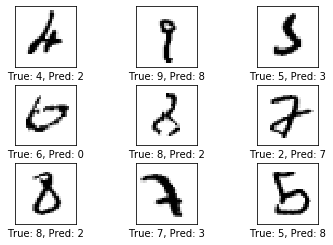

Confusion Matrix:
[[ 971    0    1    0    0    1    3    1    3    0]
 [   0 1130    3    0    0    0    1    0    1    0]
 [   1    0 1026    0    1    0    0    2    2    0]
 [   0    0    1 1005    0    0    0    1    3    0]
 [   1    0    2    0  969    0    2    3    3    2]
 [   2    0    0    6    0  879    1    0    2    2]
 [   4    2    1    1    1    4  945    0    0    0]
 [   1    1   10    2    0    0    0 1011    2    1]
 [   3    0    4    2    1    1    0    1  961    1]
 [   1    5    0    6    6    2    0    4    5  980]]


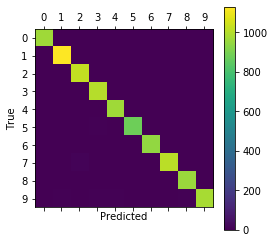

In [54]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

###Visualization of Weights and Layers
In trying to understand why the convolutional neural network can recognize handwritten digits, we will now visualize the weights of the convolutional filters and the resulting output images.

Helper-function for plotting convolutional weights

In [0]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [0]:
def plot_conv_layer(layer, image):
    # Assume layer is a TensorFlow op that outputs a 4-dim tensor
    # which is the output of a convolutional layer,
    # e.g. layer_conv1 or layer_conv2.

    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when inputting that image.
    values = session.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot the output images of all the filters.
    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i<num_filters:
            # Get the output image of using the i'th filter.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = values[0, :, :, i]

            # Plot image.
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Input Images
Helper Function for plotting image

In [0]:

def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

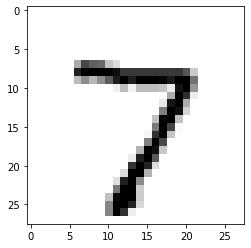

In [58]:
image1 = data.test.images[0]
plot_image(image1)

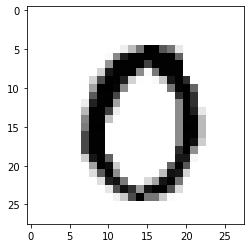

In [59]:
image2 = data.test.images[13]
plot_image(image2)

###Convolution Layer 1
Now plot the filter-weights for the first convolutional layer.

Note that positive weights are red and negative weights are blue.

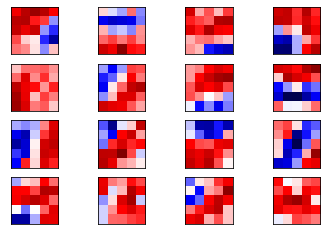

In [60]:
plot_conv_weights(weights=weights_conv1)

Applying each of these convolutional filters to the first input image gives the following output images, which are then used as input to the second convolutional layer. Note that these images are down-sampled to 14 x 14 pixels which is half the resolution of the original input image.

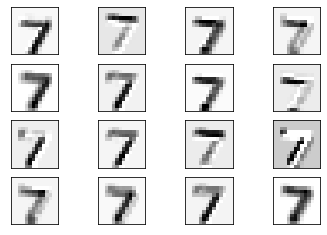

In [61]:
plot_conv_layer(layer=layer_conv1, image=image1)


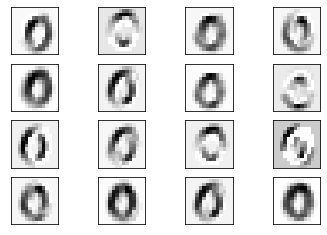

In [62]:
plot_conv_layer(layer=layer_conv1, image=image2)

###Convolution Layer 2
Now plot the filter-weights for the second convolutional layer.

There are 16 output channels from the first conv-layer, which means there are 16 input channels to the second conv-layer. The second conv-layer has a set of filter-weights for each of its input channels. We start by plotting the filter-weigths for the first channel.

Note again that positive weights are red and negative weights are blue.

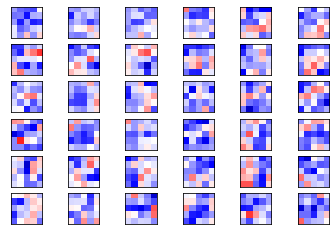

In [63]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

There are 16 input channels to the second convolutional layer, so we can make another 15 plots of filter-weights like this. We just make one more with the filter-weights for the second channel.

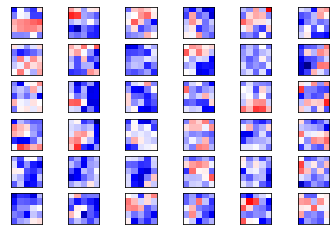

In [64]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

Applying these convolutional filters to the images that were ouput from the first conv-layer gives the following images.

Note that these are down-sampled yet again to 7 x 7 pixels which is half the resolution of the images from the first conv-layer.

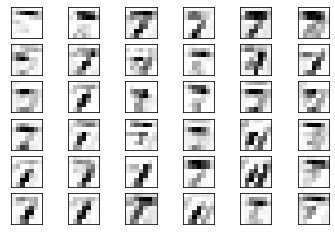

In [65]:
# First Image
plot_conv_layer(layer=layer_conv2, image=image1)

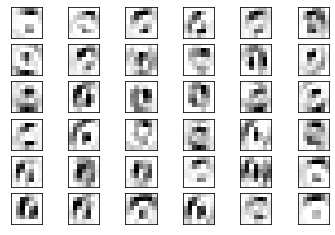

In [66]:
# Second Image
plot_conv_layer(layer=layer_conv2, image=image2)

In [0]:
session.close()